# Design draft

In [1]:
import pamtra2
import collections
import refractiveIndex
import numpy as np
import pandas as pn
import xarray as xr
from collections import OrderedDict
from copy import deepcopy, copy
import toolz
import collections
import matplotlib.pyplot as plt

try:
    %matplotlib inline
except:
    pass

In [2]:
import pyPamtraRadarSimulator



# create Profile

In [37]:
additionalDims = collections.OrderedDict()
# additionalDims['time'] = pn.date_range('2016-01-01','2016-01-05',freq='D')[:1]
# additionalDims['lat'] = np.arange(70,80)
nHeights = 100

pam2 = pamtra2.pamtra2(
    nLayer=nHeights,
    hydrometeors=['rain','snow'],
    additionalDims = additionalDims,
    frequencies = [35e9, 94e9],
)



In [38]:
pam2.profile

<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, layer: 100)
Coordinates:
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (layer) float64 nan nan nan nan nan nan nan nan nan ...
    temperature          (layer) float64 nan nan nan nan nan nan nan nan nan ...
    pressure             (layer) float64 nan nan nan nan nan nan nan nan nan ...
    relativeHumidity     (layer) float64 nan nan nan nan nan nan nan nan nan ...
    horizontalWind       (layer) float64 nan nan nan nan nan nan nan nan nan ...
    verticalWind         (layer) float64 nan nan nan nan nan nan nan nan nan ...
    eddyDissipationRate  (layer) float64 nan nan nan nan nan nan nan nan nan ...
    waterContent         (layer, hydrometeor) float64 nan nan nan nan nan ...
    wavelength           (frequency)

Fill with some dummie values

In [39]:

pam2.profile.height[:] = np.linspace(0,1000,nHeights)
pam2.profile.temperature[:] = 250 
pam2.profile.relativeHumidity[:] = 90
pam2.profile.pressure[:] = 100000
pam2.profile.eddyDissipationRate[:] = 1e-4
pam2.profile.horizontalWind[:] = 0



pam2.profile.waterContent.values[:] = 0
#rain
pam2.profile.waterContent.values[...,20:40,0] = 1e-4
#snow
pam2.profile.waterContent.values[...,20:40,1] = 2e-4



For testing, dask arrays are turned on by chunking.

In [40]:
# pam2.profile = pam2.profile.chunk({'time':1, 'hydrometeor':1, 'lat':1, 'frequency':1})
pam2.addMissingVariables()
pam2.profile 


<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, layer: 100)
Coordinates:
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (layer) float64 0.0 10.1 20.2 30.3 40.4 50.51 60.61 ...
    temperature          (layer) float64 250.0 250.0 250.0 250.0 250.0 250.0 ...
    pressure             (layer) float64 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 ...
    relativeHumidity     (layer) float64 90.0 90.0 90.0 90.0 90.0 90.0 90.0 ...
    horizontalWind       (layer) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    verticalWind         (layer) float64 nan nan nan nan nan nan nan nan nan ...
    eddyDissipationRate  (layer) float64 0.0001 0.0001 0.0001 0.0001 0.0001 ...
    waterContent         (layer, hydrometeor) float64 0.0 0.0 0.0 0.0 0.0 ...
    wavelength           (frequency) f

In [41]:
# # OR EASIER if desired: 
# pam2 = pamtra2.importers.profiles.usStandardAtmosphere(heigths)

# Describe Hydrometeors
To describe the hydrometeors, you can use functions, xr.DataArrays or scalars. Teh functions must support xr.DataArrays. The kwargs of the functions are gathered from (in this order)

1. pam2.hydrometors.name.profile variables (name must match). E.g. density (after it has been calculated) 
2. pam2.profile variables (name must match). E.g. temperature
3. Other provided kwargs (e.g. Dmin, DMax, N0 etc)
4. Default function arguments. Can be turned of with useFuncArgDefaults = False to make sure everything is explicitly covered.



In [42]:

pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidFixedDensity,
    name = 'rain', #or None, then str(index)
    nBins =40,
    sizeBounds = pamtra2.hydrometeors.size.linspaceBounds, 
    sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
    sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
    sizeDistribution = pamtra2.hydrometeors.sizeDistribution.exponentialN0WC, 
    aspectRatio = 1.0,
    mass = pamtra2.hydrometeors.mass.ellipsoid,
    density = pamtra2.hydrometeors.density.water,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.sphere,
    relativePermittivity = refractiveIndex.water.turner_kneifel_cadeddu, #replace with refractiveIndex.water.Turner.n
    scattering = pamtra2.hydrometeors.scattering.Rayleigh,
    fallVelocity = pamtra2.hydrometeors.fallVelocity.khvorostyanov01_drops,
    Dmin  = 1e-6,
    Dmax  = 1e-2,
    N0 =  8e6,
    useFuncArgDefaults = True,
)


sizeBounds <function linspaceBounds at 0x115fc87b8>
callable
sizeCenter <function boundsToMid at 0x115fc88c8>
callable
sizeBoundsWidth <function boundsWidth at 0x115fc8950>
callable
aspectRatio 1.0
not callable 1.0
density 1000.0
not callable 1000.0
mass <function ellipsoid at 0x11655ea60>
callable
crossSectionArea <function sphere at 0x316f96158>
callable
sizeDistribution <function exponentialN0WC at 0x11655ee18>
callable
relativePermittivity <function turner_kneifel_cadeddu at 0x417bb40d0>
callable
scattering <function Rayleigh at 0x316f96598>
callable
fallVelocity <function khvorostyanov01_drops at 0x417bab6a8>
callable
nBins 40
not callable 40
Dmin 1e-06
not callable 1e-06
Dmax 0.01
not callable 0.01
N0 8000000.0
not callable 8000000.0


/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/pamtra2/hydrometeors/sizeDistribution.py:301: UserWarning: Truncation effect on the PSD are not considered. I.e., typically mass is lost!
  warnings.warn('Truncation effect on the PSD are not considered. '
/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/xarray/core/computation.py:565: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)
/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


In [43]:
pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidMassSize,
    name='snow',
    nBins = 20,
    sizeBounds=pamtra2.hydrometeors.size.logspaceBounds, #function/object to call for getting sizes
    sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
    sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
    sizeDistribution = pamtra2.hydrometeors.sizeDistribution.exponentialFieldWC,
    aspectRatio = 0.6,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.powerLaw,
    mass = pamtra2.hydrometeors.mass.powerLaw,
    density = pamtra2.hydrometeors.density.softEllipsoid,
    #to do: adapt refractiveIndex routine so that mixing and RI are treated separately. 
    relativePermittivity = refractiveIndex.snow.eps,
    scattering = pamtra2.hydrometeors.scattering.Mie,
    fallVelocity = pamtra2.hydrometeors.fallVelocity.heymsfield10_particles,
    Dmin = 1e-6,
    Dmax = 1e-2,
    massSizeA = 0.0121, 
    massSizeB = 1.9,
    areaSizeA = 0.4,
    areaSizeB = 1.8,
    minDensity = 100,
    bla = 12,
    useFuncArgDefaults = True,
    )


sizeBounds <function logspaceBounds at 0x115fc8840>
callable
sizeCenter <function boundsToMid at 0x115fc88c8>
callable
sizeBoundsWidth <function boundsWidth at 0x115fc8950>
callable
aspectRatio 0.6
not callable 0.6
mass <function powerLaw at 0x11655e9d8>
callable
density <function softEllipsoid at 0x316f96268>
callable
crossSectionArea <function powerLaw at 0x316f960d0>
callable
sizeDistribution <function exponentialFieldWC at 0x11655ed08>
callable
relativePermittivity <function eps at 0x417babea0>
callable
scattering <function Mie at 0x316f96510>
callable


/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/pamtra2/hydrometeors/sizeDistribution.py:301: UserWarning: Truncation effect on the PSD are not considered. I.e., typically mass is lost!
  warnings.warn('Truncation effect on the PSD are not considered. '


fallVelocity <function heymsfield10_particles at 0x316f96730>
callable
nBins 20
not callable 20
Dmin 1e-06
not callable 1e-06
Dmax 0.01
not callable 0.01
massSizeA 0.0121
not callable 0.0121
massSizeB 1.9
not callable 1.9
areaSizeA 0.4
not callable 0.4
areaSizeB 1.8
not callable 1.8
minDensity 100
not callable 100
bla 12
not callable 12


/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping
/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/pamtra2/hydrometeors/core.py:263: UserWarning: The following kwargs were NOT used: ['bla']
  '%s' % self._keysToBeUsed)


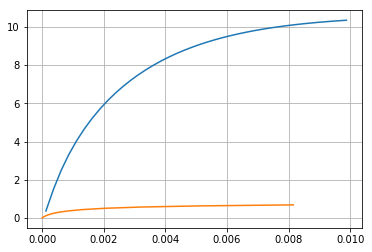

In [45]:
plt.plot(
    pam2.hydrometeors.rain.profile.sizeCenter,
    pam2.hydrometeors.rain.profile.fallVelocity.isel(layer=10))
plt.plot(
    pam2.hydrometeors.snow.profile.sizeCenter,
    pam2.hydrometeors.snow.profile.fallVelocity.isel(layer=10))

# plt.xlim(0,0.002)
plt.grid()
# plt.ylim(0,7)

The profile arrays have been populated, but they contain daks arrays. These are only placeholders, they have not been calculated yet!

In [46]:
pam2.hydrometeors.rain.profile, pam2.hydrometeors.snow.profile

(<xarray.Dataset>
 Dimensions:                  (frequency: 2, layer: 100, sizeBin: 40, sizeBin1: 41)
 Coordinates:
   * sizeBin                  (sizeBin) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
   * sizeBin1                 (sizeBin1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 ...
   * layer                    (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
   * frequency                (frequency) float64 3.5e+10 9.4e+10
 Data variables:
     sizeBounds               (sizeBin1) float64 1e-06 0.000251 0.000501 ...
     sizeCenter               (sizeBin) float64 0.000126 0.000376 0.0006259 ...
     sizeBoundsWidth          (sizeBin) float64 0.00025 0.00025 0.00025 ...
     aspectRatio              float64 1.0
     density                  float64 1e+03
     mass                     (sizeBin) float64 1.047e-09 2.782e-08 1.284e-07 ...
     crossSectionArea         (sizeBin) float64 1.247e-08 1.11e-07 3.077e-07 ...
     sizeDistribution         (sizeBin, layer) float64 0.0 0.0 0.0 0.0 0.0 ..

Force computation with e.g.
`pam2.hydrometeors.rain.profile.compute()` or `pam2.hydrometeors.rain.profile.to_netcdf()` or  or `pam2.hydrometeors.rain.profile.plot()`

# Radar simulator


In [50]:
pam2.profile['pathIntegratedAtenuattion'] = xr.zeros_like(pam2.profile.height)



pam2.addInstrument(
    pamtra2.instruments.radar.dopplerRadarPamtra,
    name = 'test',
    frequencies = 3.5e+10,    
        radarMaxV=7.885,
        radarMinV=-7.885,
        radarAliasingNyquistInterv=1,
        radarNFFT=256,
        verbosity=3,
        radarAirmotion=True,
        radarAirmotionModel="constant",  # "constant","linear","step"
        radarAirmotionVmin=0,
        radarAirmotionVmax=0,
        radarAirmotionLinearSteps=30,
        radarAirmotionStepVmin=0.5,
        radarK2=0.93,         # dielectric constant |K|² (always for liquid water by convention) for the radar equation
        radarBeamwidthDeg=0.2,
        radarIntegrationTime=60,
        radarPNoise1000=-30,
        radarNAve=150,
        seed=0,
)

RuntimeError: Error in Fortran routine simulate_radar

In [ ]:
pam2.instruments.test._calcRadarSpectrum()

In [ ]:
%debug

In [ ]:
np.ndim(np.zeros((10,10)))

# Original concept

In [ ]:

#this function will add hydrometeor confihuration to pam2.hydrometeors and 
#append hydrometeor to coordinates of e.g. pam2.profile.lwc
#Note that only the configuration will stored! All the functions
#will be calles later by the forward model! 
pam2.addHydrometeor(
    name = 'snow1', #or None, then str(index)
    index = 0, #or None, then append
    kind = 'snow', #liquid, ice
    nBins = 80,
    sizes = (
        pamtra2.hydrometeors.sizes.logspace, #function/object to call for getting sizes
        funcArgs = {
            Dmin = 1e-6,
            Dmax = 1e-4,
        }
    ),
    psd = (
        pamtra2.hydrometeors.sizeDistributions.exponentialFieldLwc, #function/object to call for getting psd
        funcArgs = {
            temperature : pam2.profile.temperature,
            lwc : pam2.profile.lwc, #test whether hydrodim is included! for all input vars!
            massSizeA : 0.01, #mass size relation required to estimate exponential doistribution from N0
            massSizeB : 1.8,
        },
    ),
    aspectRatio = (
        0.6,
    ),
    mass = (
        pamtra2.hydrometeors.mass.powerLaw, #function/object to call for getting mass
        funcArgs = {
            massSizeA : 0.01,
            massSizeB : 1.8,
        },
    ),
    density = (
        pamtra2.hydrometeors.density.softSphere, #function/object to call for getting density
        funcArgs = {
            minDensity : 100,
#             maxDensity : , defaults to ice!
        },
    ),
    crossSectionArea = (
        pamtra2.hydrometeors.area.powerLaw, #function/object to call for getting crossSectionArea
        funcArgs = {
            areaSizeA : 0.01,
            areaSizeB : 1.8,
        },
    ),
)
#for example, pamtra2.hydrometeors.area.powerLaw will be an object
# which will be called with pamtra2.hydrometeors.area.powerLaw(diameterCenter,
# areaSizeA=areaSizeA,areaSizeB=areaSizeB)



pam2.addHydrometeor(
    name = 'rain1', #or None, then str(index)
    index = 1, #or None, then append
    kind = 'liquid', #liquid, ice
    nBins =40,
    sizes = (
        pamtra2.hydrometeors.sizes.linspace, 
        funcArgs = {
            Dmin = 1e-6,
            Dmax = 1e-4,
        }
    ),
    psd = (
        pamtra2.hydrometeors.sizeDistributions.exponentialLwc, #function/object to call for getting psd
        funcArgs = {
            lwc : pam2.profile.lwc, #test whether hydrodim is included! for all input vars!
            lambd : 10,
        },
    ),
    aspectRatio = (
        pamtra2.hydrometeors.aspectRatio.rainAspectRatioModel,
        funcArgs = {
            sampleKeyword : 10, 
        },
    ),
    mass = (
        pamtra2.hydrometeors.mass.ellipsoid,
    ),
    density = (
        pamtra2.hydrometeors.density.water, # or 1000.
    ),
    crossSectionArea = (
        pamtra2.hydrometeors.area.ellipsoid,
    ),
)

#in case we already have the full spectrum!

pam2.addHydrometeor(
    name = 'ice1', #or None, then str(index)
    index = 1, #or None, then append
    kind = 'liquid', #liquid, ice
    nBins =2,
    sizes = (
        pamtra2.hydrometeors.sizes.monodispers, 
        funcArgs = {
            Dmono = 1e-5,
        },
    ),
    psd = (
        pamtra2.profiles.hydrometeor_size_distribution, #array with discrete n(D) exists, but has len ==0.
    ),
    aspectRatio = (
        1.0,
    ),
    mass = (
        pamtra2.hydrometeors.mass.ellipsoid,
    ),
    density = (
        pamtra2.hydrometeors.density.ice, # or 971.
    ),
    crossSectionArea = (
        pamtra2.hydrometeors.area.ellipsoid,
    ),
)
#now the array is prepared because addHydrometeor got an array as an argumetn for psd
pam2.profiles.hydrometeor_size_distribution.sel(hydrometeor='ice1')[:] = ICE_PSD_FROM_AIRCRAFT


#now also profile.lwc is prepare because we know how many hydrometeors we have:
pam2.profile.lwc[:] = 0.1


# OR EASIER for all of the above: 
pamtra2.importer.profiles.CosmoColumsNetcdf('COSMO_column_20170102.nc') #will take care of hydrometeors and profiles


#kazr is a copy of the pam object with added information about the instrument
kazr = pam2.createInstrument(
    name= 'KAZR'
    kind = 'dopplerRadar',
    #the pamtra2.forwardOperators.spectralRadarSimulator class will contain all the magic and create the object to be retruend
    method = pamtra2.forwardOperators.spectralRadarSimulator, 
    frequencies = [35],
    settings = {
        'nyquistVMax' : 10,
        'nyquistVMin' : -10,
        'nFFT' : 512,
        'K2': 0.92,
        ...
    }
)


#add information about scattering properties
kazr.setHydrometeorScattering(
    'rain1',
    refractiveIndex = (
        pamtra2.refractiveIndex.water, 
        funcArgs = {
            'model' : 'Turner',
        }
    ),
    singleScattering = (
        pamtra2.singleScattering.tmatrix, 
        funcArgs = {
            'cached' : True,
        },
    ),
)

kazr.setHydrometeorScattering(
    'snow1', 
    refractiveIndex = (
        pamtra2.refractiveIndex.snow, 
        funcArgs = {
            'model_mix':'Bruggeman',
            'model_ice':'Matzler_2006',
        }
    ),
    singleScattering = (
        pamtra2.singleScattering.rayleighGans, 
        funcArgs = {
        },
    ),
)

kazr.setHydrometeorScattering(
    'ice1',
    # refractiveIndex = (), For missing descriptions, default values 
    # will be used depending on particle kind!
    # singleScattering = (
    #     pamtra2.singleScattering.mie, 
    # ),
)


hatpro = pam2.createInstrument(
    name= 'Hatpro'
    kind = 'MWR',
    #pamtra2.forwardOperators.RT4 will share a lot of code with pamtra2.forwardOperators.spectralRadarSimulator
    method = pamtra2.forwardOperators.RT4, 
    frequencies = [22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.40],
    settings = {
        'bandWidths' : [0.230, 0.230, 0.230, 0.230, 0.230, 0.230, 0.230],
        ....
    }
)

#We can either copy the scattering properties or do new ones!
hatpro.setHydrometeorScattering(
...
)



ceilo = pam2.createInstrument(
    name= 'Ceilo'
    kind = 'Ceilometer',
    method = pamtra2.forwardOperators.Ceilosim, 
    wavelengths = [905],
    settings = {
        'property' : 10,
        ...
    }
)

ceilo.setHydrometeorScattering(
...
)

# OR EASIER: 
WSACR = pamtra.importer.instruments.WSACR(site='Oliktok Point',configuration='20171004')
WSACR.setHydrometeorScattering(
...
)



kazr.run() #this command runs all the functions defined above!
kazr.results.to_netcdf('kazr.nc')

hatpro.run()
hatpro.results.to_netcdf('hatpro.nc')

ceilo.run()
ceilo.results.to_netcdf('ceilo.nc')

In [ ]:
import numba

@numba.jit(nopython=False)
def modifiedGamma(sizeCenter,N0,lambd,mu=0,gamma=1):
  """
  classical modifed gamma distribution

  Parameters
  ----------
  sizeCenter : array_like
    particle size at center of size bin
  N0 : array_like
    N0 prefactor (default None)
  lambd : float or array_like
    lambda parameter (default array)
  mu : float or array_like
    mu parameter (default array)
  gamma : float or array_like
    gamma parameter (default array)

  Returns
  -------

  N : array
    particle size distribution with shape = N0.shape + sizeCenter.shape
  """

  N = N0 * sizeCenter**mu * np.exp(-lambd * sizeCenter**gamma)

  return N

In [ ]:



sizeCenter=np.zeros((1000,10,4))
sizeCenter[:] = np.logspace(-6,-2,4)
# sizeCenter =np.logspace(-6,-2,100).reshape((1000,10))
N0 = np.random.random((1000,10))
lambd = np.random.random((1000,10))

# vecFunc = np.vectorize(lambda sizeCenter,N0,lambd : modifiedGamma(sizeCenter,N0,lambd))


%timeit modifiedGamma(sizeCenter.T,N0.T,lambd.T).T